In [1]:
#数据处理，提取tsv文件
import pandas as pd
import numpy as np
import nltk
import re
import logging
import time 
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from gensim.models import word2vec
from sklearn.cluster import KMeans 
from wordcloud import WordCloud, STOPWORDS

In [2]:
#读取数据
train = pd.read_csv("data/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("data/testData.tsv", header=0, delimiter="\t", quoting=3)
unlabeled_train = pd.read_csv( "data/unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )
#train.columns.values
#train["review"][0]
train=train+test
#为保证有足够的数据集，混合label和测试集的全部5万条数据，然后按照622来划分
#可以考虑使用交叉验证
train_data,val_data,train_labels,val_labels=train_test_split(all_data,labels,test_size=0.2,random_state=0)
train_data,test_data,train_labels,test_labels=train_test_split(all_data,labels,test_size=0.25,random_state=0)

In [39]:
#数据转换函数
def review_to_words(raw_review, split=False, remove_stopwords=False,lemmatize=True):

    #使用BeautifulSoup库处理掉原始文本，去除<br />等符号
    review_text = BeautifulSoup(raw_review).get_text() 

    #使用正则表达式去除无意义的符号,即只保留a-z和空格，统一为小写
    #实际上可能需要考虑部分符号，比如表情的情感含义？
    review_text = re.sub("[^a-zA-Z]", " ", review_text)
    words=review_text.lower().split() 

    #导入停用词列表使用停用词,剔除掉所有在停用词列表里面的词汇
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops] 
    #先进行词性还原，然后再分割
    if lemmatize:
        temp = []
        temp.append(' '.join(lemmatize_all(words)))
        words=re.sub("[^a-zA-Z]", " ",str(temp) ).split()

    return temp #如果是词袋，要求输出为单词列表，而不是整个的字符串
    #return(" ".join(words)) 
    
#词性还原
def lemmatize_all(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(sentence):
        if tag.startswith('NN'):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        elif tag.startswith('R'):
            yield wnl.lemmatize(word, pos='r')
        else:
            yield word

In [40]:
clean_train_reviews = []
clean_test_reviews = [] 

for i in range( 0, train["review"].size):
    if( (i+1)%5000 == 0 ):
        print("Review %d of %d\n" % ( i+1, train["review"].size )) 
    clean_train_reviews.append( review_to_words( train["review"][i],split=True, remove_stopwords=True，lemmatize=True) )

for i in range(0,test["review"].size):
    if( (i+1) % 5000 == 0 ):
        print("Review %d of %d\n" % ( i+1, test["review"].size )) 
    clean_test_reviews.append( review_to_words( test["review"][i],split=True, remove_stopwords=True) )

Review 5000 of 25000

Review 10000 of 25000

Review 15000 of 25000

Review 20000 of 25000

Review 25000 of 25000

Review 5000 of 25000

Review 10000 of 25000

Review 15000 of 25000

Review 20000 of 25000

Review 25000 of 25000



In [41]:
clean_test_reviews[1]

['movie disaster within disaster film full great action scene meaningful throw away sense reality let see word wise lava burn steam burn stand next lava divert minor lava flow difficult let alone significant one scar think might actually believe saw movie even worse significant amount talent go make film mean act actually good effect average hard believe somebody read script allow talent waste guess suggestion would movie start tv look away like train wreck awful know come watch look away spend time meaningful content']

In [36]:
train_f = []
train_f.append(' '.join(lemmatize_all(clean_test_reviews[1])))

In [37]:
train_f=re.sub("[^a-zA-Z]", " ",str(train_f) ).split()

In [38]:
train_f

['movie',
 'disaster',
 'within',
 'disaster',
 'film',
 'full',
 'great',
 'action',
 'scene',
 'meaningful',
 'throw',
 'away',
 'sense',
 'reality',
 'let',
 'see',
 'word',
 'wise',
 'lava',
 'burn',
 'steam',
 'burn',
 'stand',
 'next',
 'lava',
 'divert',
 'minor',
 'lava',
 'flow',
 'difficult',
 'let',
 'alone',
 'significant',
 'one',
 'scar',
 'think',
 'might',
 'actually',
 'believe',
 'saw',
 'movie',
 'even',
 'worse',
 'significant',
 'amount',
 'talent',
 'go',
 'make',
 'film',
 'mean',
 'act',
 'actually',
 'good',
 'effect',
 'average',
 'hard',
 'believe',
 'somebody',
 'read',
 'script',
 'allow',
 'talent',
 'waste',
 'guess',
 'suggestion',
 'would',
 'movie',
 'start',
 'tv',
 'look',
 'away',
 'like',
 'train',
 'wreck',
 'awful',
 'know',
 'come',
 'watch',
 'look',
 'away',
 'spend',
 'time',
 'meaningful',
 'content']

In [ ]:
#使用词袋来建立特征变量,共25000个文档，使用 5000 个最常用的词
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,preprocessor = None, \
                             stop_words = None, max_features = 5000) 

# 学习全部词汇表，并选择相对数量的词汇的特征变量，将结果转换成数组
train_data_features = vectorizer.fit_transform(clean_train_reviews).toarray()

# 词汇名
vocab = vectorizer.get_feature_names()
# 统计频数
dist = np.sum(train_data_features, axis=0)

# 打出词汇名和出现的频数
#for tag, count in zip(vocab, dist):
#    print(count, tag)

In [ ]:
# 随机森林，初始化100树,其中train["sentiment"]是label
forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit( train_data_features, train["sentiment"] )

#为测试集获取一包单词，并转换成一个numpy数组
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

#使用随机森林进行情感标签预测
result = forest.predict(test_data_features)

#将结果复制到一个带有“id”列和“情感”列的熊猫数据框架中 
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

#输出文件
output.to_csv( "Bag_of_Words_model.csv", index=False, quoting=3 )

In [42]:
#Load the punkt tokenizer将段落分解成不同的句子，因为Word2Vec 需要单个句子
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

#定义一个函数，将一篇评论拆分成已解析的句子
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    #函数将一篇评论拆分成已解析的句子。返回句子列表，其中每个句子都是单词列表
    #用NLTK分词器将段落分成句子
    raw_sentences = tokenizer.tokenize(review.strip())

    sentences = []
    for raw_sentence in raw_sentences:
        #如果一个句子是空的，跳过它
        if len(raw_sentence) > 0:
            #否则，调用review_to_wordlist来获取单词列表
            sentences.append( review_to_words( raw_sentence,split=True, remove_stopwords=True, lemmatize=True))
    #返回句子列表(每个句子都是一个单词列表，所以这将返回一个列表列表
    return sentences

sentences = []  
for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer)

for review in unlabeled_train["review"]:
    sentences += review_to_sentences(review, tokenizer)

E:\anaconda_neve\envs\amls2\lib\site-packages\bs4\__init__.py:408: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


In [45]:
type(sentences)

list

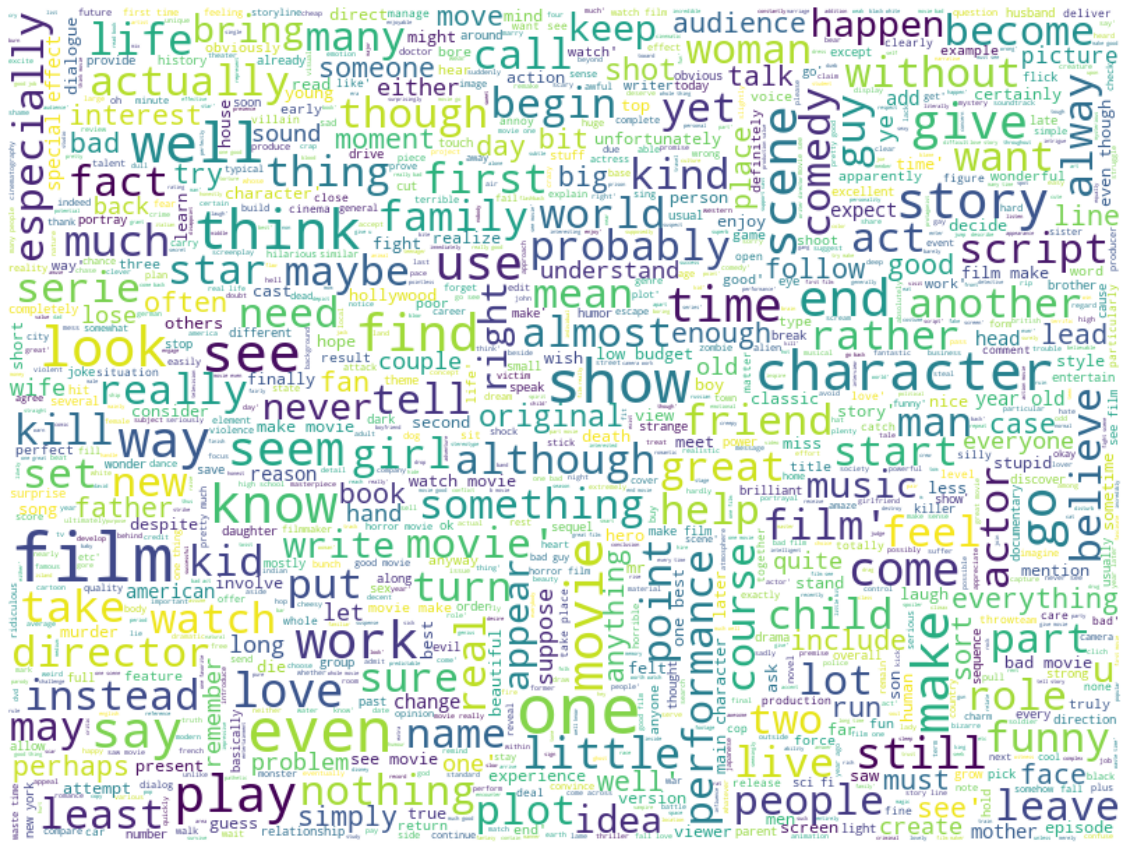

In [46]:
def plot_wordcloud(text):
    wc = WordCloud(background_color="white",# 设置背景颜色
               max_words=2000, # 词云显示的最大词数
               height=600, # 图片高度
               width=800, # 图片宽度
               max_font_size=50, #最大字体     
               stopwords=set(STOPWORDS)) # 设置停用词
    wc.generate(str(text)) #
    fig = plt.figure(figsize=(20,20))
    plt.imshow(wc, interpolation='bilinear') # interpolation='bilinear' 表示插值方法为双线性插值
    plt.axis("off")# 关掉图像的坐标
    plt.show()
plot_wordcloud(str(sentences))

In [60]:
len(sentences)

63153022

In [62]:
sentences[0]

' '

TypeError: sub() missing 2 required positional arguments: 'repl' and 'string'

In [ ]:
# 使用Word2Vec算法
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

#设置相关word2vec参数
num_features = 500    # 词向量维度                 
min_word_count = 40   # 最小字数。任何在所有文档中至少出现这么多次的单词都会被忽略。将词汇量限制为有意义的单词                     
num_workers = 4       # 并行运行的线程数量，但 4 到 6 之间应该适用于大多数系统。
context = 10          # 上下文窗口大小；训练算法应该考虑多少上下文词，10 似乎适用于分层 softmax（在一定程度上，越多越好）。                                                                              
downsampling = 1e-3   # 常用词的缩减取样设置，Google 文档建议使用介于 0.00001 和 0.001 之间的值。

#初始化并训练模型(这需要一些时间)
model = word2vec.Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count = min_word_count,window = context, sample = downsampling)

#如果您不打算进一步训练模型，调用init_sims将使模型更加节省内存。
model.init_sims(replace=True)

#创建一个有意义的模型名称并保存模型以备后用会很有帮助。您可以稍后使用Word2Vec.load()加载它
model_name = "300features_40minwords_10context"
model.save(model_name)

In [49]:
#doesnt_match方法将尝试推断出集合中哪个词与其他词最不相似
model.wv.doesnt_match("man woman child kitchen".split())

2022-04-10 16:19:24,257 : WARNING : vectors for words {'child', 'kitchen', 'woman', 'man'} are not present in the model, ignoring these words


ValueError: cannot select a word from an empty list

In [53]:
#most_similar函数来深入了解模型的词簇
model.wv.most_similar("man")

KeyError: "Key 'man' not present"

In [54]:
#获取模型的大小
model.wv.vectors.shape

(135, 500)

In [ ]:
#读取模型的方法
#model = word2vec.load("300features_40minwords_10context")

In [ ]:
#获取具体的变量的特征值
#model.wv["flower"] 

In [61]:
# 函数计算给定段落中所有单词向量的平均值
# 向量平均法
def makeFeatureVec(words, model, num_features):
    
    # 初始化空数组
    featureVec = np.zeros((num_features,),dtype="float32")
    
    nwords = 0.
    #Index2word是一个包含模型词汇表中单词名称的列表。为了速度，把它转换成一组
    index2word_set = set(model.wv.key_to_index)

    #循环检查评论中的每个单词，如果它在模型的词汇中，将其特征向量添加到总数featureVec中
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model.wv[word])
    # 将结果除以字数，得到平均值
    featureVec = np.divide(featureVec,nwords)
    return featureVec

#给定一组评论(每个评论都是一个单词列表)，计算每个评论的平均特征向量，并返回一个2D数字数组
def getAvgFeatureVecs(reviews, model, num_features):
   
    #初始化变量
    counter = 0

    #为了提高速度，预先分配一个2D数字数组
    reviewFeatureVecs = np.zeros([len(reviews),num_features],dtype="float32")
    #浏览评论
    for review in reviews:
        #每第5000次检查时打印一条状态消息
        if counter%5000 == 0:
            print("Review %d of %d" % (counter, len(reviews)))
        #调用产生平均特征向量的makeFeatureVec函数
        #print(counter)
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        #featureVec= makeFeatureVec(review, model,num_features)
        #递增计数器
        counter = counter + 1
    return reviewFeatureVecs

In [50]:
a=np.zeros([6,5],dtype="float32")
a[1]
b=np.zeros(5,dtype="float32")
#b

In [62]:
#使用上面定义的函数计算训练集和测试集的平均特征向量。请注意，我们现在使用停用词删除。
clean_train_reviews = []
for review in train["review"]:
    clean_train_reviews.append(review_to_words( review, remove_stopwords=True ))
    
trainDataVecs= getAvgFeatureVecs( clean_train_reviews, model, num_features )
print("Creating average feature vecs for train reviews")

clean_test_reviews = []
for review in test["review"]:
    clean_test_reviews.append( review_to_words( review,remove_stopwords=True ))

testDataVecs= getAvgFeatureVecs( clean_test_reviews, model, num_features )
print("Creating average feature vecs for test reviews")

Review 0 of 25000
Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000
Creating average feature vecs for train reviews
Review 0 of 25000
Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000
Creating average feature vecs for test reviews


In [ ]:
#获取所有变量名的列表
#list(model.wv.key_to_index)

In [64]:
# 使用100棵树的随机森林，其中train["sentiment"]是label

forest = RandomForestClassifier( n_estimators = 100 )

forest = forest.fit( trainDataVecs, train["sentiment"] )

# Test & extract results 
result = forest.predict( testDataVecs )

# Write the test results 
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv( "Word2Vec_AverageVector.csv", index=False, quoting=3 )

In [75]:
#使用K平均聚类法
start = time.time() # Start time

#将k(num _ clusters)设置为词汇量的1/5，或者每个簇平均5个单词
word_vectors = model.wv.vectors
num_clusters = int(word_vectors.shape[0] / 5)

#初始化一个k-means对象，并使用它来提取质心,传入kmean的必须是int类型
kmeans_clustering = KMeans( n_clusters = num_clusters ) 
idx = kmeans_clustering.fit_predict( word_vectors )

#获取结束时间并打印该过程花费的时间
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

Time taken for K Means clustering:  1143.2601804733276 seconds.


In [74]:
num_clusters = int(word_vectors.shape[0] / 5)
num_clusters

3298

In [94]:
#创建一个单词/索引字典，将每个词汇单词映射到一个簇号                                                                                            
word_centroid_map = dict(zip( model.wv.index_to_key, idx ))

# For the first 10 clusters
for cluster in range(0,10):
    #打印簇编号
    print("\nCluster %d" % cluster)
    #找出该簇编号的所有单词，并将其打印出来
    words = []
    for i in range(0,len(word_centroid_map.values())):
        if(list(word_centroid_map.values())[i] == cluster):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['national', 'lampoon', 'geographic']

Cluster 1
['peter', 'blake', 'edwards']

Cluster 2
['scheme', 'blackmail']

Cluster 3
['subtle', 'understated', 'restrained', 'nuanced', 'subdued', 'relaxed', 'detached', 'grounded', 'naturalistic', 'disconcerting', 'showy', 'offset', 'underplayed']

Cluster 4
['trading', 'tumble']

Cluster 5
['sky', 'rain', 'fog', 'shades', 'grass', 'glow', 'clouds', 'cloth', 'skies', 'mist', 'sunlight', 'raining']

Cluster 6
['titular', 'recurring', 'echoes', 'eponymous', 'mai', 'venom']

Cluster 7
['gates', 'buffalo', 'cody', 'wolverine', 'garrison', 'quarry', 'calamity', 'thorn', 'ffolkes', 'hickok', 'yeager', 'mendoza', 'hickock']

Cluster 8
['liberation']

Cluster 9
['hopeless', 'prostitution', 'openly', 'repressed', 'stricken', 'sordid', 'budding', 'alienated', 'liberated', 'promiscuous', 'functioning', 'unfulfilled', 'deviant', 'endures', 'puberty', 'carnal', 'cruelly']


In [91]:
word_centroid_map = dict(zip( model.wv.index_to_key, idx ))
list(word_centroid_map.values())[2]

834

In [95]:
#质心袋函数将评论转换为质心袋。这就像 Bag of Words 一样工作，但使用语义相关的集群而不是单个单词
def create_bag_of_centroids( wordlist, word_centroid_map ):

    #聚类的数量等于单词/质心图中的最高聚类索引
    num_centroids = max( word_centroid_map.values() ) + 1

    #预分配质心矢量包(为了速度)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    
    #循环评论中的单词。如果这个单词在词汇表中，找到它属于哪个簇，并将该簇的计数加1
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
               
    return bag_of_centroids

In [96]:
#为质心的训练集包预先分配一个数组(为了速度) 
train_centroids = np.zeros( (train["review"].size, num_clusters),dtype="float32" )

#将训练集评论转换成质心包
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids( review, word_centroid_map )
    counter += 1

#处理测试集 
test_centroids = np.zeros(( test["review"].size, num_clusters), dtype="float32" )

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids( review, word_centroid_map )
    counter += 1

In [97]:
#拟合随机森林并提取预测
forest = RandomForestClassifier(n_estimators = 100)

print("Fitting a random forest to labeled training data...")
forest = forest.fit(train_centroids,train["sentiment"])
result = forest.predict(test_centroids)

output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv( "BagOfCentroids.csv", index=False, quoting=3 )

Fitting a random forest to labeled training data...


In [99]:
#准确率的函数
def classified_correct(model, i):
    return (model["sentiment"][i] == 0 and int(model["id"][i].split("_")[1]) <= 5) or \
           (model["sentiment"][i] == 1 and int(model["id"][i].split("_")[1]) > 5)

model = pd.read_csv("BagOfCentroids.csv");
correct = np.array([classified_correct(model,i) for i in range(model.shape[0])])
print(correct.sum() / model.shape[0]) # the accuracy

0.84712


In [104]:
classified_correct(model,2)

False

In [ ]:
fig = plt.figure(figsize=(20,20)) # rows*cols 
rows = 2
cols = 1

for i in range(2):
    wordcloud = plot_wordcloud(train[train['sentiment']==i]['review'])
    ax = fig.add_subplot(rows, cols, i+1)
    
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(wordcloud)
    #plt.show()